# AIsteroid
[http://bit.ly/aisteroid](http://bit.ly/aisteroid)

In [1]:
from aisteroid import *
%matplotlib nbagg

## Task: Stitch fields

### Choose the set list

In [46]:
if QIPY:
    CONF.SET_LIST="sets.list" ##List of image sets to compile information
    CONF.SET_LIST="sets-NEA.list" ##List of image sets to compile information
    CONF.SET_LIST="sets-jan2018.list" ##List of image sets to compile information
    CONF.CAMPAIGN="jan2018"
    CONF.VERBOSE=0
    CONF.OVERWRITE=0 ##WARNING-WARNING-WARNING

#### DO NOT TOUCH IF YOU ARE NOT SURE

In [47]:
print0("*"*60+"\nSTITCHING IMAGES FOR SET LIST '%s'\n"%CONF.SET_LIST+"*"*60)

if not os.path.isfile(CONF.SET_LIST):
    error("Set list '%s' does not exist"%CONF.SET_LIST)
    
SET_LIST_NAME=CONF.SET_LIST.split("/")[-1].replace(".list","")
TEAMS_FILE=CONF.DATA_DIR+"sets/teams-%s.txt"%CONF.CAMPAIGN
CAMPS_FILE=CONF.DATA_DIR+"sets/campaign-%s.txt"%CONF.CAMPAIGN

CONF.REP_DIR="data/reports/"
PLOT_DIR=CONF.REP_DIR

REP_FILE=CONF.REP_DIR+SET_LIST_NAME+"-report.aia"
if os.path.isfile(REP_FILE):
    REP=pickle.load(open(REP_FILE,"rb"))
    sets=REP["sets"]
    allobjects=REP["allobjects"]
else:
    error("You must run first the report")

************************************************************
STITCHING IMAGES FOR SET LIST 'sets-jan2018.list'
************************************************************


### Generate transformation and polygons

In [48]:
print0("Generating transformations and polygons")
if not "pols" in REP.keys() or CONF.OVERWRITE:
    wcs=dict()
    pols=dict()
    for i,ind in enumerate(sets.index):
        iset=sets.loc[ind]
        set_name=iset["set_name"]
        print("\tAnalysing set %d '%s'"%(i,set_name))

        #Get data for set
        OUT_DIR=CONF.SCR_DIR+set_name+"/"
        if not os.path.isdir(OUT_DIR):
            print0("\t\tSet %s not yet unpacked. Skipping"%set_name)
            continue
        AIA_FILE=OUT_DIR+"%s.aia"%(set_name)
        if not os.path.isfile(AIA_FILE):
            print0("\t\tSet %s not yet analysed. Skipping"%set_name)
            continue

        AIA=pickle.load(open(AIA_FILE,"rb"))
        images=AIA["images"]
        nimgs=len(images)
        print1("\t\tNumber of images:",len(images))
        borders=AIA["borders"]
        print1("\t\tNumber of border points:",len(borders[0]))
        sources=AIA["sources"]
        print1("\t\tNumber of sources:",len(sources[sources.IMG==0]))
        objects=AIA["objects"]
        nobj=len(objects)
        print1("\t\tNumber of objects:",nobj)

        #Check dateini 
        date_ini=iset["date_ini"]
        if not date_ini in pols.keys():
            pols[date_ini]=[]
            wcs[date_ini]=[]

        #Fint transformation from x,y to RA,DEC
        tr=AffineTransform()
        bright=sources[sources.MAG_ASTRO<20]
        status=tr.estimate(bright[["X_IMAGE","Y_IMAGE"]].values,
                           bright[["RA","DEC"]].values)

        #Box
        ny,nx=images[0]["data"].shape
        bs=polygonGen(0,0,nx,ny,7,4)
        bsky=np.array([tr(bs[i,:])[0] for i in range(bs.shape[0])])

        #Preserve
        wcs[date_ini]+=[tr]
        pols[date_ini]+=[[ind,images[0],sources[sources.IMG==0],bsky]]

        #if i>100:break
    
    #Save
    REP["pols"]=pols
    REP["wcs"]=wcs
    pickle.dump(REP,open(REP_FILE,"wb"))
    print0("Done.")
else:
    print("\tPolygons already calculated.")
    pols=REP["pols"]
    wcs=REP["wcs"]

Generating transformations and polygons
	Polygons already calculated.


### Show Polygons

Showing stitching
	Date 2018-01-08T08:42:41.172957
		Plotting 43 fields
	Date 2018-01-07T06:44:20.991472
		Plotting 76 fields
	Date 2018-01-08T08:44:32.464539
		Plotting 182 fields
	Date 2018-01-08T08:46:23.537403
		Plotting 1 fields
	Done.


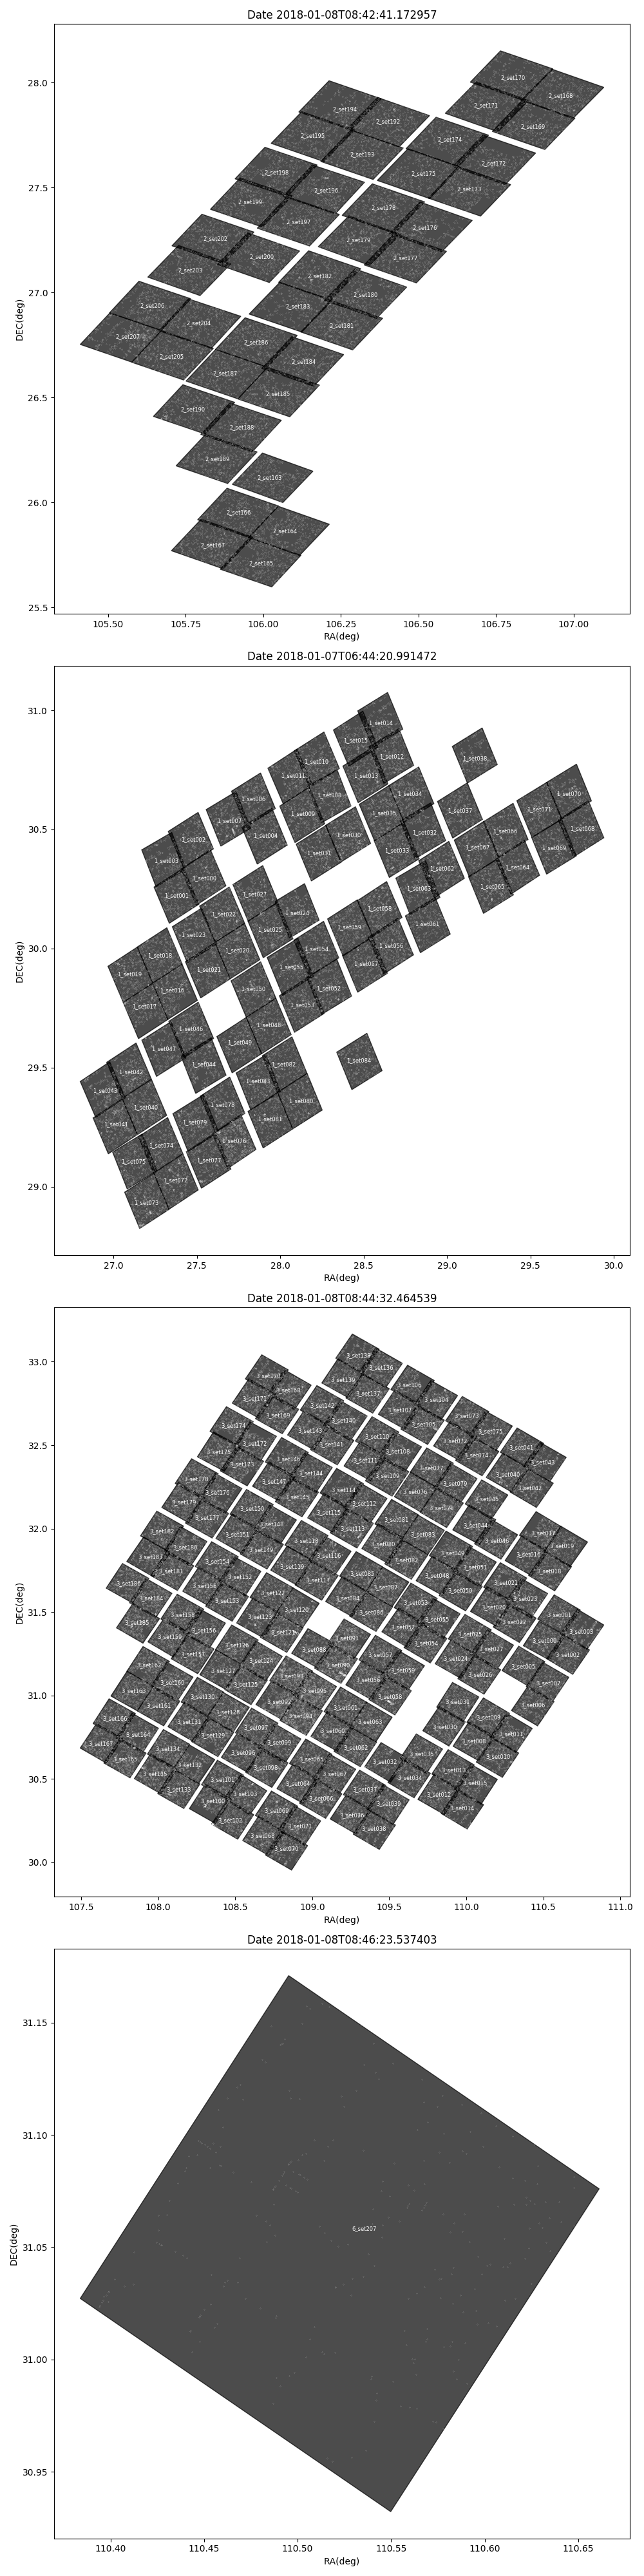

In [83]:
plotfile=PLOT_DIR+"stitch-%s.png"%SET_LIST_NAME
CONF.OVERWRITE=1
if CONF.QPLOT:
    plt.ioff() ##Comment to see interactive figure

    print0("Showing stitching")
    if not os.path.isfile(plotfile) or CONF.OVERWRITE:
        
        ndates=len(pols.keys())
        fig,axs=plt.subplots(ndates,1,figsize=(10,10*ndates))        

        for i,date in enumerate(pols.keys()):
            print("\tDate %s"%(date))
            #if date!="2018-01-08T08:44:32.464539":continue
            print("\t\tPlotting %d fields"%(len(pols[date])))
            axs[i].set_title("Date %s"%date)
            axs[i].set_xlabel("RA(deg)")
            axs[i].set_ylabel("DEC(deg)")
            j=0
            for pol in pols[date]:
                j+=1
                indset,images,sources,bsky=pol
                if np.abs(sources.RA.mean())<1e-3:continue
                set_name=sets.loc[indset,"set_name"]
                poli=pat.Polygon(bsky,closed=True,color='k',alpha=0.7)
                axs[i].add_patch(poli)
                axs[i].plot(sources.RA,sources.DEC,'wo',ms=0.1)
                axs[i].text(sources.RA.mean(),sources.DEC.mean(),set_name[-8:],
                                ha='center',va='center',fontsize=6,color='w')
                #break
    
        fig.tight_layout()
        #waterMark(axs)
        fig.savefig(plotfile)
    else:
        if CONF.QPLOT:print0("\tImage '%s' already generated."%plotfile)
    print0("\tDone.")
Image(filename=plotfile)

In [85]:
#poly_proj = Polygon(bs)
#point=Point([3000,1000])
#point.within(poly_proj)